## Attacker Activity Patterns

In [1]:
import os
import pandas as pd
from glob import glob

DAILY_DIR = "../../data/daily"  # Update as needed

all_files = sorted(glob(os.path.join(DAILY_DIR, "http_day_2025-*.csv")))
unique_ips = set()

for f in all_files:
    df = pd.read_csv(f, usecols=['clientIP'])
    unique_ips.update(df['clientIP'].dropna().unique())

print(f"Total number of unique clientIP addresses: {len(unique_ips)}")

Total number of unique clientIP addresses: 176899


Aggregate the data from top 100 IP

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load all CSVs into a single DataFrame (adjust path as needed)
from glob import glob
all_files = glob('../../data/daily/http_day_2025-*.csv')
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

# 2. Get Top 100 IPs
top_ips = df['clientIP'].value_counts().head(100).index.tolist()
df_top = df[df['clientIP'].isin(top_ips)]

# 3. Sort by clientIP and startTime
df_top['startTime'] = pd.to_datetime(df_top['startTime'])
df_top = df_top.sort_values(['clientIP', 'startTime'])
df_top.to_csv("top100_ips_all_requests.csv", index=False)

/tmp/ipykernel_3731747/633659987.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['startTime'] = pd.to_datetime(df_top['startTime'])


Behavior Analysis

/tmp/ipykernel_115887/1294081285.py:4: DtypeWarning: Columns (6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_top = pd.read_csv("top100_ips_all_requests.csv")


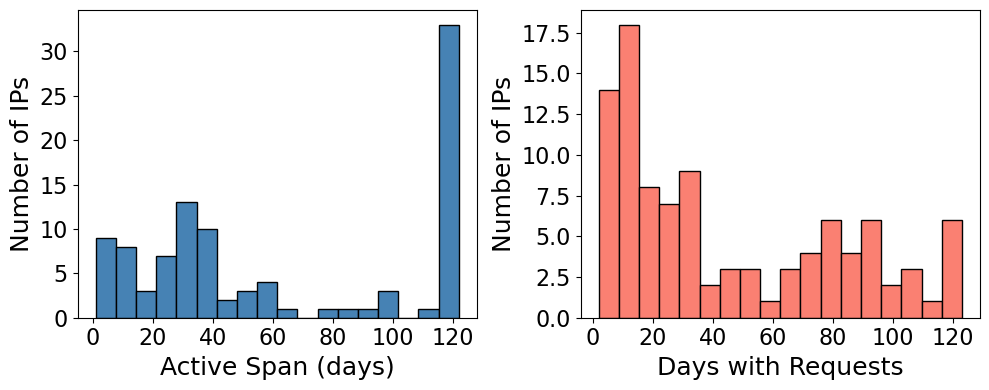

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_top = pd.read_csv("top100_ips_all_requests.csv")
df_top['startTime'] = pd.to_datetime(df_top['startTime'])

# Active span and burstiness
active_span = df_top.groupby('clientIP')['startTime'].agg(['min', 'max'])
active_span['span_days'] = (active_span['max'] - active_span['min']).dt.days
active_span['burst_days'] = df_top.groupby('clientIP')['startTime'].apply(lambda x: x.dt.date.nunique())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(active_span['span_days'], bins=18, color='steelblue', edgecolor='k')
plt.xlabel('Active Span (days)', fontsize=18)
plt.ylabel('Number of IPs', fontsize=18)
#plt.title('How Long Each IP is Active')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,2,2)
plt.hist(active_span['burst_days'], bins=18, color='salmon', edgecolor='k')
plt.xlabel('Days with Requests', fontsize=18)
plt.ylabel('Number of IPs', fontsize=18)
#plt.title('Burstiness: Days with Requests per IP')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig("../../data/lowrate/ip_activity.pdf", bbox_inches='tight')


### Categorize IP Behavior Types
**Classic burst:** Most requests in a short period (e.g., >80% in a single day)  
**Steady daily:** Requests spread across most days  
**Short Burst:** Only active <= 3 days

In [2]:
import pandas as pd
import numpy as np

df_top = pd.read_csv("top100_ips_all_requests.csv")
df_top['startTime'] = pd.to_datetime(df_top['startTime'])
df_top['date'] = df_top['startTime'].dt.date

ip_group = df_top.groupby('clientIP')

summary = []

for ip, group in ip_group:
    total_days = group['date'].nunique()
    total_requests = len(group)
    max_per_day = group.groupby('date').size().max()
    burst_ratio = max_per_day / total_requests
    summary.append({
        "clientIP": ip,
        "total_days": total_days,
        "total_requests": total_requests,
        "burst_ratio": burst_ratio
    })

summary_df = pd.DataFrame(summary)


/tmp/ipykernel_115887/3603872138.py:4: DtypeWarning: Columns (6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_top = pd.read_csv("top100_ips_all_requests.csv")


In [3]:
# Classic burst: High burst_ratio (>0.8), active >1 day, top 5 by total_requests
burst_ips = summary_df[(summary_df['burst_ratio'] > 0.8) & (summary_df['total_days'] > 1)] \
    .sort_values('total_requests', ascending=False)['clientIP'].head(5).tolist()

# Steady daily: Active >15 days, burst_ratio <0.4, top 5 by total_requests
steady_ips = summary_df[(summary_df['total_days'] > 15) & (summary_df['burst_ratio'] < 0.4)] \
    .sort_values('total_requests', ascending=False)['clientIP'].head(5).tolist()

# Short-burst: Active <= 3 days, top 5 by total_requests
shortburst_ips = summary_df[summary_df['total_days'] <= 3] \
    .sort_values('total_requests', ascending=False)['clientIP'].head(5).tolist()


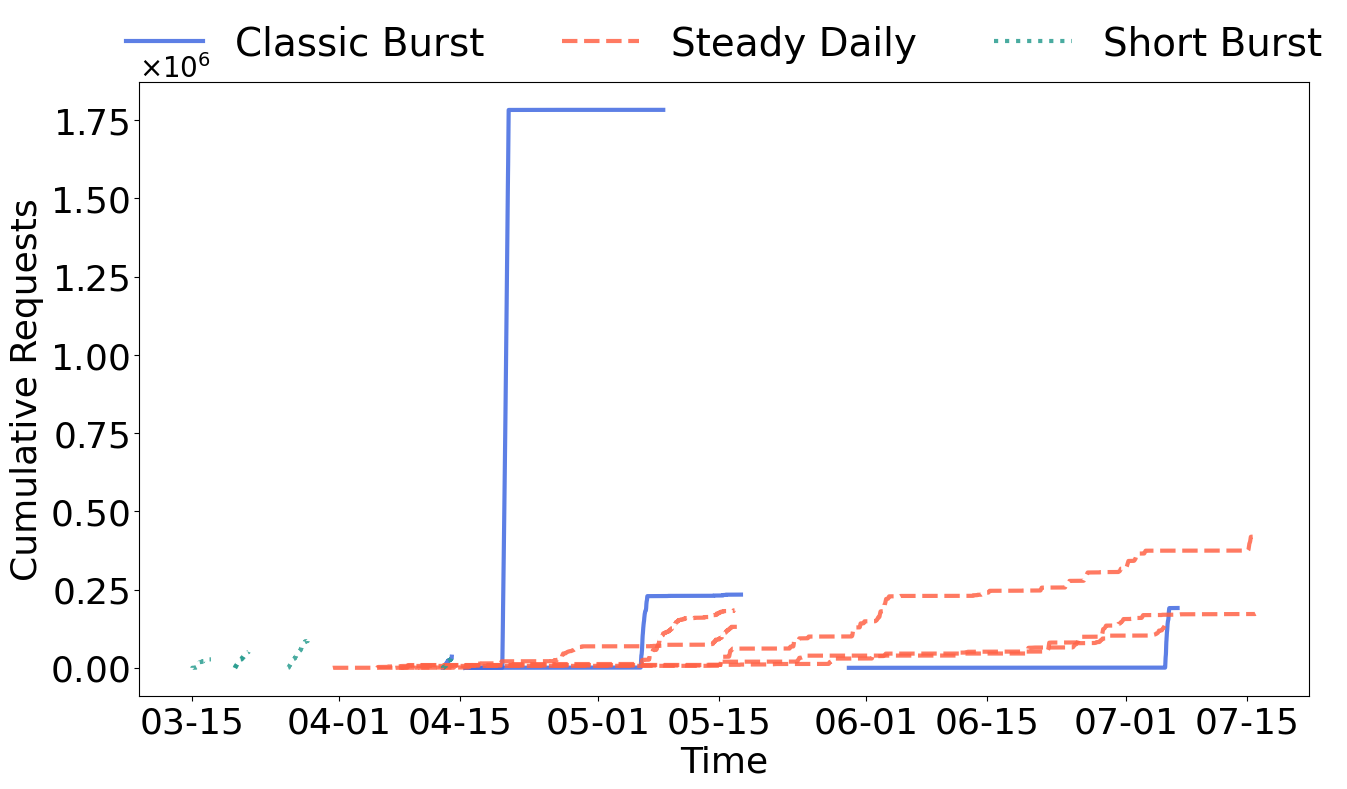

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(14, 8))

# Plot classic burst
for ip in burst_ips:
    subset = df_top[df_top['clientIP'] == ip]
    ax.plot(
        subset['startTime'], range(len(subset)),
        alpha=0.85, color='royalblue', linestyle="-",
        label='Classic Burst' if ip == burst_ips[0] else "",
        linewidth=3
    )

# Plot steady
for ip in steady_ips:
    subset = df_top[df_top['clientIP'] == ip]
    ax.plot(
        subset['startTime'], range(len(subset)),
        alpha=0.85, color='tomato', linestyle="--",
        label='Steady Daily' if ip == steady_ips[0] else "",
        linewidth=3
    )

# Plot short burst
for ip in shortburst_ips:
    subset = df_top[df_top['clientIP'] == ip]
    ax.plot(
        subset['startTime'], range(len(subset)),
        alpha=0.85, color='#299d8f', linestyle=":",
        label='Short Burst' if ip == shortburst_ips[0] else "",
        linewidth=3
    )

# Format y-axis (scientific notation, larger offset)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.offsetText.set_fontsize(20)

# Axis labels and ticks
ax.set_xlabel("Time", fontsize=26)
ax.set_ylabel("Cumulative Requests", fontsize=26)
ax.tick_params(axis='x', labelsize=26)
ax.tick_params(axis='y', labelsize=26)

# Legend on top
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False,
    fontsize=28
)

# X-axis: show only month-day (no year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))

plt.tight_layout()
plt.savefig("../../data/lowrate/ip_patterns.pdf", bbox_inches='tight')
plt.show()


Quantitive

In [5]:
# Define type selection
burst_ips = summary_df[(summary_df['burst_ratio'] > 0.8) & (summary_df['total_days'] > 1)]['clientIP'].tolist()
steady_ips = summary_df[(summary_df['total_days'] > 15) & (summary_df['burst_ratio'] < 0.4)]['clientIP'].tolist()
shortburst_ips = summary_df[(summary_df['total_days'] <= 3) & (summary_df['total_days'] > 1)]['clientIP'].tolist()

In [6]:
for type_name, ip_list in zip(
        ["Classic Burst", "Steady Daily", "Short Burst"],
        [burst_ips, steady_ips, shortburst_ips]):
    print(f"\nType: {type_name}")
    group_df = df_top[df_top['clientIP'].isin(ip_list)]
    print(group_df['category'].value_counts(normalize=True))  # Percentage by type



Type: Classic Burst
category
intrusion-control    0.794227
attempt              0.202866
scan                 0.002907
Name: proportion, dtype: float64

Type: Steady Daily
category
attempt              0.617650
intrusion-control    0.223958
scan                 0.158393
Name: proportion, dtype: float64

Type: Short Burst
category
attempt              0.588426
intrusion-control    0.411033
scan                 0.000541
Name: proportion, dtype: float64


In [7]:
import pandas as pd
df_top = pd.read_csv("top100_ips_all_requests.csv")

# If not already sorted:
df_top = df_top.sort_values(['clientIP', 'startTime'])

# For each IP, extract sequence of categories and their timestamps
category_transitions = []
for ip, ip_df in df_top.groupby('clientIP'):
    ip_df = ip_df.sort_values('startTime')
    # Ensure all timestamps are datetime
    ip_df['startTime'] = pd.to_datetime(ip_df['startTime'], errors='coerce')

    # Get the FIRST occurrence time for each category (will be NaT if not present)
    times = {cat: ip_df[ip_df['category'] == cat]['startTime'].min() for cat in ['scan', 'attempt', 'intrusion-control']}

    # Only proceed if all are timestamps (not NaT)
    if all([pd.notnull(times[c]) for c in ['scan', 'attempt', 'intrusion-control']]):
        if times['scan'] <= times['attempt'] <= times['intrusion-control']:
            esc_gap_1 = (times['attempt'] - times['scan']).total_seconds()/3600  # hours
            esc_gap_2 = (times['intrusion-control'] - times['attempt']).total_seconds()/3600
            category_transitions.append({
                'clientIP': ip,
                'scan_time': times['scan'],
                'attempt_time': times['attempt'],
                'control_time': times['intrusion-control'],
                'gap_scan_attempt_hr': esc_gap_1,
                'gap_attempt_control_hr': esc_gap_2,
                'progressed': True
            })
        else:
            category_transitions.append({'clientIP': ip, 'progressed': False})
    else:
        category_transitions.append({'clientIP': ip, 'progressed': False})


transitions_df = pd.DataFrame(category_transitions)


/tmp/ipykernel_335069/3018100201.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_top = pd.read_csv("top100_ips_all_requests.csv")


In [9]:
# --- Count IPs with all three in order ---
all_three_progressed = transitions_df['progressed'].sum()
total_with_all_three = transitions_df['progressed'].notnull().sum()
print(f"IPs with full 3-stage escalation (scan→attempt→intrusion-control): {all_three_progressed}")

# --- Now, for all pairs, check progression for any two categories ---
pair_transitions = []

for ip, ip_df in df_top.groupby('clientIP'):
    ip_df = ip_df.sort_values('startTime')
    ip_df['startTime'] = pd.to_datetime(ip_df['startTime'], errors='coerce')
    categories = ip_df['category'].tolist()
    times = ip_df['startTime'].tolist()

    # Find indices for each category (first occurrence)
    try:
        idx_scan = categories.index('scan')
    except ValueError:
        idx_scan = None
    try:
        idx_attempt = categories.index('attempt')
    except ValueError:
        idx_attempt = None
    try:
        idx_control = categories.index('intrusion-control')
    except ValueError:
        idx_control = None

    pairs = []
    if idx_scan is not None and idx_attempt is not None and idx_scan < idx_attempt:
        pairs.append('scan→attempt')
    if idx_attempt is not None and idx_control is not None and idx_attempt < idx_control:
        pairs.append('attempt→intrusion-control')
    if idx_scan is not None and idx_control is not None and idx_scan < idx_control:
        pairs.append('scan→intrusion-control')
    if pairs:
        pair_transitions.append({'clientIP': ip, 'pairs': pairs})

# Summarize
from collections import Counter
all_pairs = [p for entry in pair_transitions for p in entry['pairs']]
pair_counts = Counter(all_pairs)

print(f"Number of IPs with any 2-stage escalation:")
for pair, count in pair_counts.items():
    print(f"  {pair}: {count}")

print(f"\nTotal unique IPs with at least one 2-stage escalation: {len(pair_transitions)}")


IPs with full 3-stage escalation (scan→attempt→intrusion-control): 16


Number of IPs with any 2-stage escalation:
  scan→attempt: 37
  attempt→intrusion-control: 25
  scan→intrusion-control: 36

Total unique IPs with at least one 2-stage escalation: 51
